In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='CAG')|(df['Sub-task A']=='OAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
  return df

In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Minor Project/wiki.bn.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
train_df=load_csv("/content/drive/My Drive/Minor Project/iben_train.csv")
dev_df=load_csv("/content/drive/My Drive/Minor Project/iben_dev.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0                                      Dada taratari           0
1                              Tumi korbe Amar sathe           0
2  Ar ta chara a sob bessha peter cheleder okhan ...           2
3                   কাকের শরীরে ময়ুরের পাখা লাগিয়েছে           1
4  পতিতাদের চরিত্র রাজনৈতিক নেতাদের থেকে হাজার গু...           0
                                                Text  Sub-task A
0  Ek dom sothik kotha bolecho jhekane theka uthe...           0
1                                        ফালতু মেয়ে           1
2                                   DARUN AKDOM THIK           0
3                                     Sala ranu magi           2
4                                থামবেল ঠিককোরে বানা           2


In [0]:
train_df.shape,dev_df.shape

((3826, 2), (957, 2))

In [0]:
Y_train=train_df['Sub-task A']
Y_train

0       0
1       0
2       2
3       1
4       0
       ..
3821    0
3822    1
3823    1
3824    0
3825    0
Name: Sub-task A, Length: 3826, dtype: int64

In [0]:
Y_dev=dev_df['Sub-task A']
Y_dev

0      0
1      1
2      0
3      2
4      2
      ..
952    1
953    0
954    0
955    0
956    0
Name: Sub-task A, Length: 957, dtype: int64

In [0]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    2078
1     898
2     850
Name: Sub-task A, dtype: int64
0    522
1    218
2    217
Name: Sub-task A, dtype: int64


In [0]:
# importing Word2Vec
from gensim.models import Word2Vec
from gensim.models import FastText

In [0]:
#load pre-trained embedding:
embeddings_index = {}
f = open('/content/wiki.bn.vec', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:]) # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in wiki.bin.vec.' % len(embeddings_index))

Total 145279 word vectors in wiki.bin.vec.


In [0]:
embeddings_index['the'].shape

(300,)

In [0]:
tk=Tokenizer()
tk.fit_on_texts(train_df['Text'])
word_index=tk.word_index
#print(index)
train_df = tk.texts_to_sequences(train_df['Text'])
dev_df=tk.texts_to_sequences(dev_df['Text'])

In [0]:
embedding_vecor_length =30
train_df = pad_sequences(train_df, maxlen=embedding_vecor_length, padding='post')
print (train_df)

[[    3  1240     0 ...     0     0     0]
 [   47   607    72 ...     0     0     0]
 [   32     4   492 ...     0     0     0]
 ...
 [  143   564   414 ...     0     0     0]
 [10558    42     0 ...     0     0     0]
 [ 3465 10559    48 ...     0     0     0]]


In [0]:
embedding_vecor_length =30
dev_df = pad_sequences(dev_df, maxlen=embedding_vecor_length, padding='post')
print (dev_df)

[[ 296  311 1853 ...    0    0    0]
 [ 306  857    0 ...    0    0    0]
 [  35   51    7 ...    0    0    0]
 ...
 [  14  644    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   3   77   54 ...    0    0    0]]


In [0]:
 # Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index), EMBEDDING_DIM))
#embedding_matrix = (16433, 100) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word+'1') # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(Y_train))
y_test = to_categorical(np.asarray(Y_dev))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(3826, 3) (957, 3)


In [0]:
vocab_size=len(word_index)
vocab_size

10562

In [0]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Input,LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model=Sequential()
model.add(Embedding(vocab_size,100,input_length=train_df.shape[1]))
model.add(LSTM(192, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           1056200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 192)               225024    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 579       
Total params: 1,281,803
Trainable params: 1,281,803
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(train_df, y_train, validation_data = (dev_df, y_test),epochs=100,batch_size=100, verbose=2)

Train on 3826 samples, validate on 957 samples
Epoch 1/100
 - 3s - loss: 1.0157 - acc: 0.5342 - val_loss: 1.0032 - val_acc: 0.5455
Epoch 2/100
 - 2s - loss: 0.9602 - acc: 0.5674 - val_loss: 0.9461 - val_acc: 0.5904
Epoch 3/100
 - 2s - loss: 0.6775 - acc: 0.6683 - val_loss: 0.7921 - val_acc: 0.6092
Epoch 4/100
 - 2s - loss: 0.5006 - acc: 0.7344 - val_loss: 0.8470 - val_acc: 0.6395
Epoch 5/100
 - 2s - loss: 0.4310 - acc: 0.7548 - val_loss: 1.1038 - val_acc: 0.5935
Epoch 6/100
 - 2s - loss: 0.3804 - acc: 0.7784 - val_loss: 1.2087 - val_acc: 0.6123
Epoch 7/100
 - 2s - loss: 0.3716 - acc: 0.7922 - val_loss: 1.4018 - val_acc: 0.5423
Epoch 8/100
 - 2s - loss: 0.3702 - acc: 0.8298 - val_loss: 1.1551 - val_acc: 0.6489
Epoch 9/100
 - 2s - loss: 0.2945 - acc: 0.8811 - val_loss: 1.2475 - val_acc: 0.6625
Epoch 10/100
 - 2s - loss: 0.2325 - acc: 0.9219 - val_loss: 1.3560 - val_acc: 0.6562
Epoch 11/100
 - 2s - loss: 0.1616 - acc: 0.9537 - val_loss: 1.1290 - val_acc: 0.6834
Epoch 12/100
 - 2s - loss: 

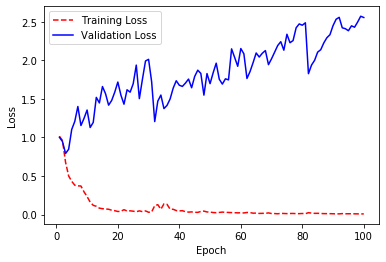

In [0]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
scores = model.evaluate(dev_df, y_test, verbose=0)
print(scores)

[2.5569211729143357, 0.6666666670403635]


In [0]:
predicting_df = pd.read_csv("/content/drive/My Drive/Minor Project/iben_test.csv")
test_df=tk.texts_to_sequences(predicting_df['Text'])
embedding_vecor_length =30
test_df = pad_sequences(test_df, maxlen=embedding_vecor_length, padding='post')
predictions_test = model.predict(test_df)
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1
predictions_test1 = predictions_test1.argmax(1)
predictions_test1 = pd.Series(predictions_test1)
predictions_test1 = predictions_test1.rename("Label")
ps = predicting_df['ID']
output_df = pd.merge(ps,predictions_test1,how='outer',left_index=True,right_index=True)
output_df['Label'] = output_df['Label'].map({0: 'NAG',1: 'CAG',2: 'OAG'})
output_df.head()

,ID,Label
0,C52.4.1,NAG
1,C52.4.2,NAG
2,C52.6,CAG
3,C52.7,NAG
4,C52.10,CAG


In [0]:
output_df.to_csv("Bangla_TaskA_Run1_LSTM_Fasttext.csv")

In [0]:
predictions_test = model.predict(dev_df)
print(predictions_test)

[[9.9997854e-01 1.4345827e-05 7.1939285e-06]
 [9.8463815e-01 1.4636671e-02 7.2518544e-04]
 [9.9982041e-01 1.7613416e-04 3.5077364e-06]
 ...
 [9.9997330e-01 2.0262052e-05 6.3800253e-06]
 [9.9958402e-01 4.1018226e-04 5.8030369e-06]
 [9.9997950e-01 1.3726219e-05 6.8167606e-06]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       522
           1       0.48      0.40      0.43       218
           2       0.63      0.59      0.60       217

   micro avg       0.67      0.67      0.67       957
   macro avg       0.61      0.60      0.60       957
weighted avg       0.66      0.67      0.66       957
 samples avg       0.67      0.67      0.67       957

